LibAUC Experiments

In [143]:
from libauc.models import resnet18
from libauc.losses import AUCMLoss

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator


from libauc.losses import AUCMLoss, CrossEntropyLoss
from libauc.optimizers import PESG, Adam
from libauc.models import densenet121 as DenseNet121
from libauc.datasets import CheXpert

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore") 

In [163]:
# data_flag = 'pathmnist'
data_flag = 'adrenalmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 16
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', download=download)

Using downloaded and verified file: C:\Users\Hari\.medmnist\adrenalmnist3d.npz


In [164]:
np.unique(train_dataset.labels, return_counts=True)

(array([0, 1], dtype=uint8), array([929, 259], dtype=int64))

In [152]:
#Breast
# 400/147 = 2.72
#PneumoniaMNIST
# 3494/1214 = 2.87
#Vessel
# 150/1185 = 8
#Nodule
# 2.92
#Synapse
# 900/330 = 2.72
# Adrenal
# 930/260 = 3.6


2.8780889621087313

In [165]:
930/260

3.576923076923077

In [183]:
# # preprocessing
# data_transform = transforms.Compose([
#     transforms.ToTensor(),
#     # transforms.Grayscale(3),
#     transforms.Resize((28, 28)), 
#     transforms.Normalize(mean=[.5], std=[.5])
# ])

data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.Grayscale(3),
            transforms.ToTensor(),
            transforms.Resize((32, 32)), 
            
            transforms.Normalize(0.5, 0.5),
        ])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = torch_data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = torch_data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = torch_data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Hari\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\Hari\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\Hari\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\Hari\.medmnist\breastmnist.npz


In [29]:
data[0].shape

torch.Size([16, 1, 32, 32])

## BEST CE Result for BMNIST below

In [36]:
from libauc.models import resnet18
from libauc.losses import AUCMLoss

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator


from libauc.losses import AUCMLoss, CrossEntropyLoss
from libauc.optimizers import PESG, Adam
from libauc.models import densenet121 as DenseNet121
from libauc.datasets import CheXpert

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore") 


data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 16
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Data Transformation
data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.Grayscale(3),
            transforms.ToTensor(),
            transforms.Resize((32, 32)), 
            
            transforms.Normalize(0.5, 0.5),
        ])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = torch_data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = torch_data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = torch_data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)




# BEST CROSS ENTROPY 
lr = 1e-5
weight_decay = 2e-5
model = resnet18(num_classes=2)
model = model.cuda()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# training
best_val_auc = 0 
for epoch in range(201):
    train_losses = []
    for idx, data in enumerate(train_loader):
      train_data, train_labels = data
      train_data, train_labels  = train_data.cuda(), train_labels.cuda()
      y_pred = model(train_data)
      loss = criterion(y_pred, train_labels.squeeze().type(torch.LongTensor).cuda())
      train_losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if epoch%5==0:
      print("Epoch : {:03d}  Train Loss : {:.5f}  ".format(epoch, np.mean(train_losses)), end='')
      model.eval()
      with torch.no_grad():    
          test_pred = []
          test_true = [] 
          test_losses = []
          for jdx, data in enumerate(test_loader):
              test_data, test_labels = data
              test_data = test_data.cuda()
              y_pred = model(test_data)
              test_pred.append(y_pred.cpu().detach().numpy())
              test_true.append(test_labels.numpy())
              test_losses.append(criterion(y_pred, test_labels.squeeze().type(torch.LongTensor).cuda()).item())

          test_true = np.concatenate(test_true)
          test_pred = np.concatenate(test_pred)
          val_auc_mean =  roc_auc_score(test_true.squeeze(), test_pred[:,1]) 
          print("Val Loss : {:.5f}   ".format(np.mean(test_losses)), end='')
          model.train()

          if best_val_auc < val_auc_mean:
              best_val_auc = val_auc_mean
              torch.save(model.state_dict(), 'ce_pretrained_model.pth')

          print ('BatchID= {}   Val_AUC={:.4f}   Best_Val_AUC={:.4f}'.format(
              idx, val_auc_mean, best_val_auc ))

Epoch : 000  Train Loss : 0.96551  Val Loss : 0.71291   BatchID= 34   Val_AUC=0.6009   Best_Val_AUC=0.6009
Epoch : 005  Train Loss : 0.46612  Val Loss : 0.53674   BatchID= 34   Val_AUC=0.7830   Best_Val_AUC=0.7830
Epoch : 010  Train Loss : 0.32923  Val Loss : 0.45366   BatchID= 34   Val_AUC=0.7993   Best_Val_AUC=0.7993
Epoch : 015  Train Loss : 0.27267  Val Loss : 0.44311   BatchID= 34   Val_AUC=0.8248   Best_Val_AUC=0.8248
Epoch : 020  Train Loss : 0.24289  Val Loss : 0.41883   BatchID= 34   Val_AUC=0.8331   Best_Val_AUC=0.8331
Epoch : 025  Train Loss : 0.20464  Val Loss : 0.41020   BatchID= 34   Val_AUC=0.8348   Best_Val_AUC=0.8348
Epoch : 030  Train Loss : 0.18576  Val Loss : 0.37117   BatchID= 34   Val_AUC=0.8707   Best_Val_AUC=0.8707
Epoch : 035  Train Loss : 0.16647  Val Loss : 0.36983   BatchID= 34   Val_AUC=0.8761   Best_Val_AUC=0.8761
Epoch : 040  Train Loss : 0.15724  Val Loss : 0.38295   BatchID= 34   Val_AUC=0.8860   Best_Val_AUC=0.8860
Epoch : 045  Train Loss : 0.13732  Va

In [23]:
# # # preprocessing
# # data_transform = transforms.Compose([
# #     transforms.ToTensor(),
# #     # transforms.Grayscale(3),
# #     transforms.Resize((28, 28)), 
# #     transforms.Normalize(mean=[.5], std=[.5])
# # ])

# train_transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.ToPILImage(),
#             transforms.Grayscale(3),
#             transforms.ToTensor(),
#             transforms.Resize((32, 32)),  
#             transforms.RandomHorizontalFlip(0.3),
#             transforms.RandomVerticalFlip(0.3),
#             # transforms.RandomEqualize(0.3),    
#             # transforms.RandomErasing([p, scale, ratio, value, inplace]),
#             # transforms.AutoAugment(),               
#             # transforms.ElasticTransform(),
#             transforms.RandomRotation(30),
#             transforms.Normalize(0.5, 0.5),
#         ])

# test_transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.ToPILImage(),
#             transforms.Grayscale(3),
#             transforms.ToTensor(),
#             transforms.Resize((32, 32)),             
#             transforms.Normalize(0.5, 0.5),
#         ])

# # load the data
# train_dataset = DataClass(split='train', transform=train_transform, download=download)
# test_dataset = DataClass(split='test', transform=data_transform, download=download)

# pil_dataset = DataClass(split='train', download=download)

# # encapsulate data into dataloader form
# train_loader = torch_data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# train_loader_at_eval = torch_data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
# test_loader = torch_data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


lr = 0.01 # using smaller learning rate is better
epoch_decay = 2e-5
weight_decay = 1e-7
margin = 1.0

model = resnet18(num_classes=2)
model = model.cuda()
# criterion = nn.CrossEntropyLoss()  
# optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=criterion, 
                 lr=lr, 
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)
CE_loss = nn.CrossEntropyLoss()
# training
best_val_auc = 0 
for epoch in range(1001):
    train_losses = []
    for idx, data in enumerate(train_loader):
      train_data, train_labels = data
      train_data, train_labels  = train_data.cuda(), train_labels.cuda()
      y_pred = model(train_data)
      y_pred = torch.sigmoid(y_pred)
      loss = criterion(y_pred, train_labels.squeeze().type(torch.LongTensor).cuda())
      train_losses.append(loss.item()/len(data))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      writer.add_scalar('train_loss', loss.item()/len(data), epoch*len(train_loader) + idx)
      writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch*len(train_loader) + idx)
        
      # validation  
    #   if idx % 10 == 0:
    
    if epoch%5==0:
      print("Epoch : {:03d}  Train Loss : {:.5f} ".format(epoch, np.mean(train_losses)), end='')
      model.eval()
      with torch.no_grad():    
          test_pred = []
          test_true = [] 
          test_losses = []
          test_CE_losses = []
          for jdx, data in enumerate(test_loader):
              test_data, test_labels = data
              test_data = test_data.cuda()
              y_pred = model(test_data)
              test_pred.append(y_pred.cpu().detach().numpy())
              test_true.append(test_labels.numpy())
              test_losses.append(criterion(y_pred, test_labels.squeeze().type(torch.LongTensor).cuda()).item() / len(data))
              test_CE_losses.append(CE_loss(y_pred, test_labels.squeeze().type(torch.LongTensor).cuda()).cpu())

          test_true = np.concatenate(test_true)
          test_pred = np.concatenate(test_pred)
          val_auc_mean =  roc_auc_score(test_true.squeeze(), test_pred[:,1]) 
          print("Val Loss : {:.5f}   Val CE Loss : {:.5f}  ".format(np.mean(test_losses), np.mean(test_CE_losses)), end = '')

          writer.add_scalar('val_loss', loss.item()/len(data), epoch*len(train_loader)+ idx)
          model.train()

          if best_val_auc < val_auc_mean:
              best_val_auc = val_auc_mean
              torch.save(model.state_dict(), 'ce_pretrained_model.pth')

          print ('BatchID= {}   Val_AUC={:.4f}   Best_Val_AUC={:.4f}'.format(
              idx, val_auc_mean, best_val_auc ))

Epoch : 000  Train Loss : 0.05583 Val Loss : 0.29575   Val CE Loss : 0.66258  BatchID= 34   Val_AUC=0.5000   Best_Val_AUC=0.5000
Epoch : 005  Train Loss : 0.07771 Val Loss : 1.41475   Val CE Loss : 0.75123  BatchID= 34   Val_AUC=0.7849   Best_Val_AUC=0.7849
Epoch : 010  Train Loss : 0.07795 Val Loss : 1.50810   Val CE Loss : 0.73419  BatchID= 34   Val_AUC=0.6963   Best_Val_AUC=0.7849
Epoch : 015  Train Loss : 0.05773 Val Loss : 1.38280   Val CE Loss : 0.62850  BatchID= 34   Val_AUC=0.8292   Best_Val_AUC=0.8292
Epoch : 020  Train Loss : 0.05557 Val Loss : 2.23650   Val CE Loss : 0.83351  BatchID= 34   Val_AUC=0.7563   Best_Val_AUC=0.8292
Epoch : 025  Train Loss : 0.06032 Val Loss : 23.92871   Val CE Loss : 3.99335  BatchID= 34   Val_AUC=0.6314   Best_Val_AUC=0.8292
Epoch : 030  Train Loss : 0.05303 Val Loss : 1.93910   Val CE Loss : 0.67281  BatchID= 34   Val_AUC=0.7515   Best_Val_AUC=0.8292
Epoch : 035  Train Loss : 0.05422 Val Loss : 421.74452   Val CE Loss : 3.08126  BatchID= 34   Va

'PESG '

In [119]:
np.unique(train_dataset.labels, return_counts=True)

(array([0, 1], dtype=uint8), array([147, 399], dtype=int64))

In [147]:
training_params = {'DATASET' : dataset,
                    'BATCH_SIZE':batch_size, 
                    'INITIAL_LR':lr, 
                    'OPTIMIZER': optimizer,
                    'OPTIMIZER_PARAMS': optimizer_params,
                    'DATA_TRANSFORMATIONS': [data_transformations],
                    'WEIGHT_DECAY': weight_decay,
                    'LOSS': loss_function}

# Possible value for each keys
# LR, Training Error, Validation Error, Best Val AUC score, Val AUC score
epoch_params = {}

tensor(0.7321, device='cuda:0')

In [19]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import time
dataset = 'breastmnist'
filename = dataset+'_'+str(int(time.time()))
writer = SummaryWriter('../runs/'+filename)

In [120]:
dir(libauc.optimizers)

['Adam',
 'F',
 'Optimizer',
 'PDSCA',
 'PESG',
 'SGD',
 'SOAP',
 'SONG',
 'SOPA',
 'SOPAs',
 'SOTAs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'adam',
 'copy',
 'math',
 'nn',
 'pdsca',
 'pesg',
 'required',
 'sgd',
 'soap',
 'song',
 'sopa',
 'sopa_s',
 'sota_s',
 'torch']

In [2]:
!pip install tensorboard

                                              0.0/5.6 MB ? eta -:--:--
                                              0.0/5.6 MB ? eta -:--:--
                                              0.0/5.6 MB 487.6 kB/s eta 0:00:12
     -                                        0.2/5.6 MB 1.5 MB/s eta 0:00:04
     ---                                      0.5/5.6 MB 3.1 MB/s eta 0:00:02
     --------                                 1.1/5.6 MB 5.6 MB/s eta 0:00:01
     ------------                             1.8/5.6 MB 6.7 MB/s eta 0:00:01
     -----------------                        2.4/5.6 MB 7.7 MB/s eta 0:00:01
     --------------------                     2.9/5.6 MB 8.2 MB/s eta 0:00:01
     -------------------------                3.6/5.6 MB 8.9 MB/s eta 0:00:01
     ------------------------------           4.3/5.6 MB 9.5 MB/s eta 0:00:01
     ----------------------------------       4.9/5.6 MB 9.7 MB/s eta 0:00:01
     --------------------------------------   5.4/5.6 MB 9.9 MB/s eta 0:00:0

In [1]:
target

NameError: name 'target' is not defined

In [22]:
model.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [114]:
import libauc
dir(libauc.losses)

['APLoss',
 'AUCMLoss',
 'AUCMLoss_V1',
 'AUCMLoss_V2',
 'AUCM_MultiLabel',
 'AUCM_MultiLabel_V1',
 'AUCM_MultiLabel_V2',
 'CompositionalAUCLoss',
 'CompositionalAUCLoss_V1',
 'CompositionalAUCLoss_V2',
 'CrossEntropyLoss',
 'F',
 'FocalLoss',
 'GCLoss',
 'GlobalContrastiveLoss',
 'ListwiseCELoss',
 'ListwiseCE_Loss',
 'NDCGLoss',
 'NDCG_Loss',
 'TopPush_Loss',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'auc',
 'concat_all_gather',
 'constrastive',
 'dist',
 'dok_matrix',
 'logistic_loss',
 'losses',
 'losses_v1',
 'nn',
 'np',
 'pAUCLoss',
 'pAUC_CVaR_Loss',
 'pAUC_DRO_Loss',
 'pAUC_Loss',
 'perf_at_top',
 'ranking',
 'squared_hinge_loss',
 'squared_loss',
 'surrogate',
 'torch',
 'tpAUC_KL_Loss']

In [62]:
to_write = [{'data_flag': 'breastmnist', 'output_root': './output', 'num_epochs': 100, 'gpu_ids': '0', 'batch_size': 16, 'download': False, 'resize': True, 'as_rgb': False, 'model_path': None, 'model_flag': 'resnet18', 'loss': 'CE', 'lr': 0.001, 'margin': 1.0, 'optimizer': 'Adam', 'epoch_decay': 2e-05, 'weight_decay': 1e-07, 'gamma': 0.1, 'run': 'model1'}]


import json

with open('./Test_file.txt', 'w', encoding="utf8") as file:
    json.dump(to_write, file)
    # file_data

In [72]:
with open('./Test_file_v2.txt', 'r', encoding="utf8") as file:
    file_data = json.load(file)
file_data

[{'data_flag': 'breastmnist',
  'output_root': './output',
  'num_epochs': 100,
  'gpu_ids': '0',
  'batch_size': 16,
  'download': False,
  'resize': True,
  'as_rgb': False,
  'model_path': None,
  'model_flag': 'resnet18',
  'loss': 'CE',
  'lr': 0.001,
  'margin': 1.0,
  'optimizer': 'Adam',
  'epoch_decay': 2e-05,
  'weight_decay': 1e-07,
  'gamma': 0.1,
  'run': 'model1'}]

In [70]:
with open('../output/breastmnist/230502/Best_metrics_of_each_run.txt')

# HALVE VAL - DO FOR SYNAPSE MNIST 

<Figure size 7680x5760 with 0 Axes>

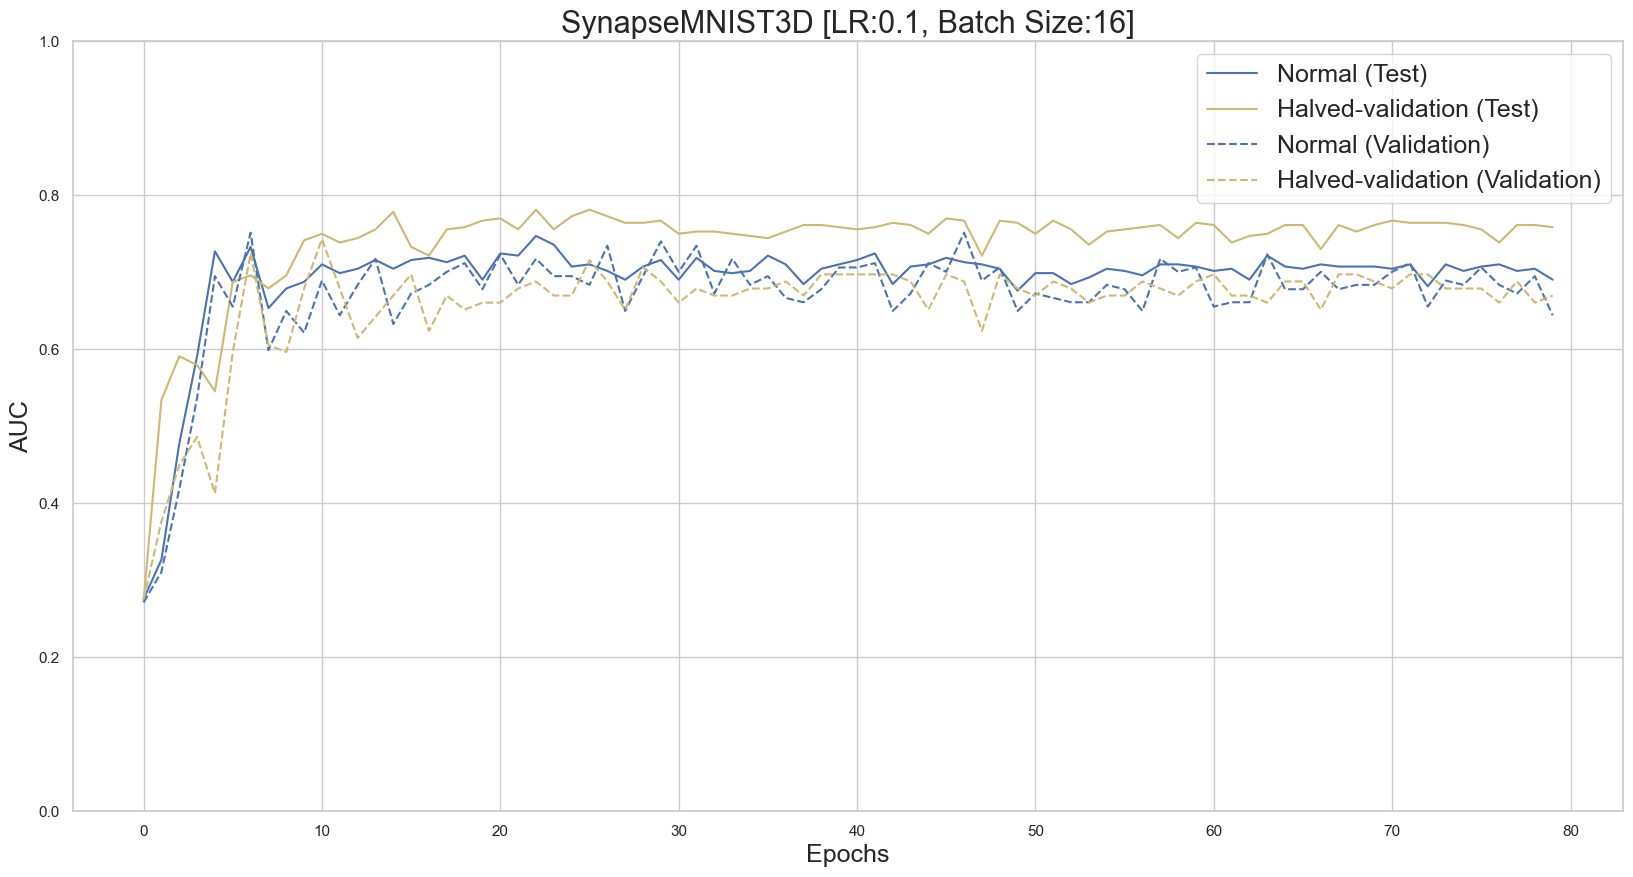

In [167]:
import seaborn as sns

# # Read from the Best Metric File file
# with open(r'E:\Deep_AUC_Optimization\Exps_using_val_scores\003_Vessel_Nodule_HP_tuninig_with_n_without_valset_modification\vesselmnist3d\Epoch_Logs\BatchSz_16_LR_0.1_Optimizer_PESG_LossFn_AUCM_Margin_1.0_EpochDecay_2e-05_WeightDecay_1e-07', 'r') as f:
#     data = json.loads(f.read())

path_1 = r'E:\Deep_AUC_Optimization_Copy\output\synapsemnist3d\Epoch_Logs\BSz_16_LR_0.1_Optim_PESG_LossFn_AUCM_Margin_1.0_ED_2e-05_WD_1e-07halve_val'
# Read epoch logs
with open(path_1, 'r') as f:
    data = eval(f.read())
data_df = pd.DataFrame.from_dict(data)
data_df_1 = data_df.T
data_df_1['Epoch'] = [i for i in range(data_df_1.shape[0])]
# df_melted = data_df[['Epoch', 'test_auc', 'val_auc']].melt("Epoch",var_name="Auc Type",value_name="AUC")
# df_melted['Auc Type'] = df_melted['Auc Type'].apply(lambda x:x.split('_')[0].capitalize())
# df_melted.head()

path_2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\007_Adrenal_Synapse_HP_tuninh_with_n_without_valset_modification\synapsemnist3d\Epoch_Logs\BatchSz_32_LR_0.1_Optimizer_PESG_LossFn_AUCM_Margin_1.0_EpochDecay_2e-05_WeightDecay_1e-07'
# Read epoch logs
with open(path_2, 'r') as f:
    data = eval(f.read())
data_df = pd.DataFrame.from_dict(data)
data_df_2 = data_df.T
data_df_2['Epoch'] = [i for i in range(data_df_2.shape[0])]
# df_melted = data_df[['Epoch', 'test_auc', 'val_auc']].melt("Epoch",var_name="Auc Type",value_name="AUC")
# df_melted['Auc Type'] = df_melted['Auc Type'].apply(lambda x:x.split('_')[0].capitalize())
# df_melted.head()



sns.set(style='whitegrid')
plt.figure(dpi=1200)
# sns.lineplot(x=[i for i in range(80)], y='test_auc', data=data_df.T, legend='auto')
# sns.lineplot(x=[i for i in range(80)], y='val_auc', data=data_df.T, legend = 'auto')
# sns.lineplot(x=[i for i in range(80)], y=['test_auc', 'val_auc'], data=data_df.T, legend = 'auto')
plt.figure(figsize=(20,10))
# sns.lineplot(x='Epoch', y='AUC', hue = 'Auc Type', data=df_melted)
# plt.plot(data_df_1['Epoch'], data_df_1['test_acc'], 'r')
plt.plot(data_df_2['Epoch'], data_df_2['test_acc'], 'b')
# plt.plot(data_df_3['Epoch'], data_df_3['test_acc'], 'k')
plt.plot(data_df_1['Epoch'], data_df_1['test_acc'], 'y')
# plt.plot(data_df_1['Epoch'], data_df_1['val_acc'], '--', 'r')
plt.plot(data_df_2['Epoch'], data_df_2['val_acc'], '--b')
# plt.plot(data_df_3['Epoch'], data_df_3['val_acc'], '--', 'k')
plt.plot(data_df_1['Epoch'], data_df_1['val_acc'], '--y')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('AUC', fontsize=18)
plt.ylim([0.0,1])
plt.title('SynapseMNIST3D [LR:0.1, Batch Size:16]', fontsize=22)
plt.legend(['Normal (Test)', 'Halved-validation (Test)', 'Normal (Validation)', 'Halved-validation (Validation)'], fontsize=18)
# plt.legend(fontsize=22)

## Data Augmentation

<Figure size 7680x5760 with 0 Axes>

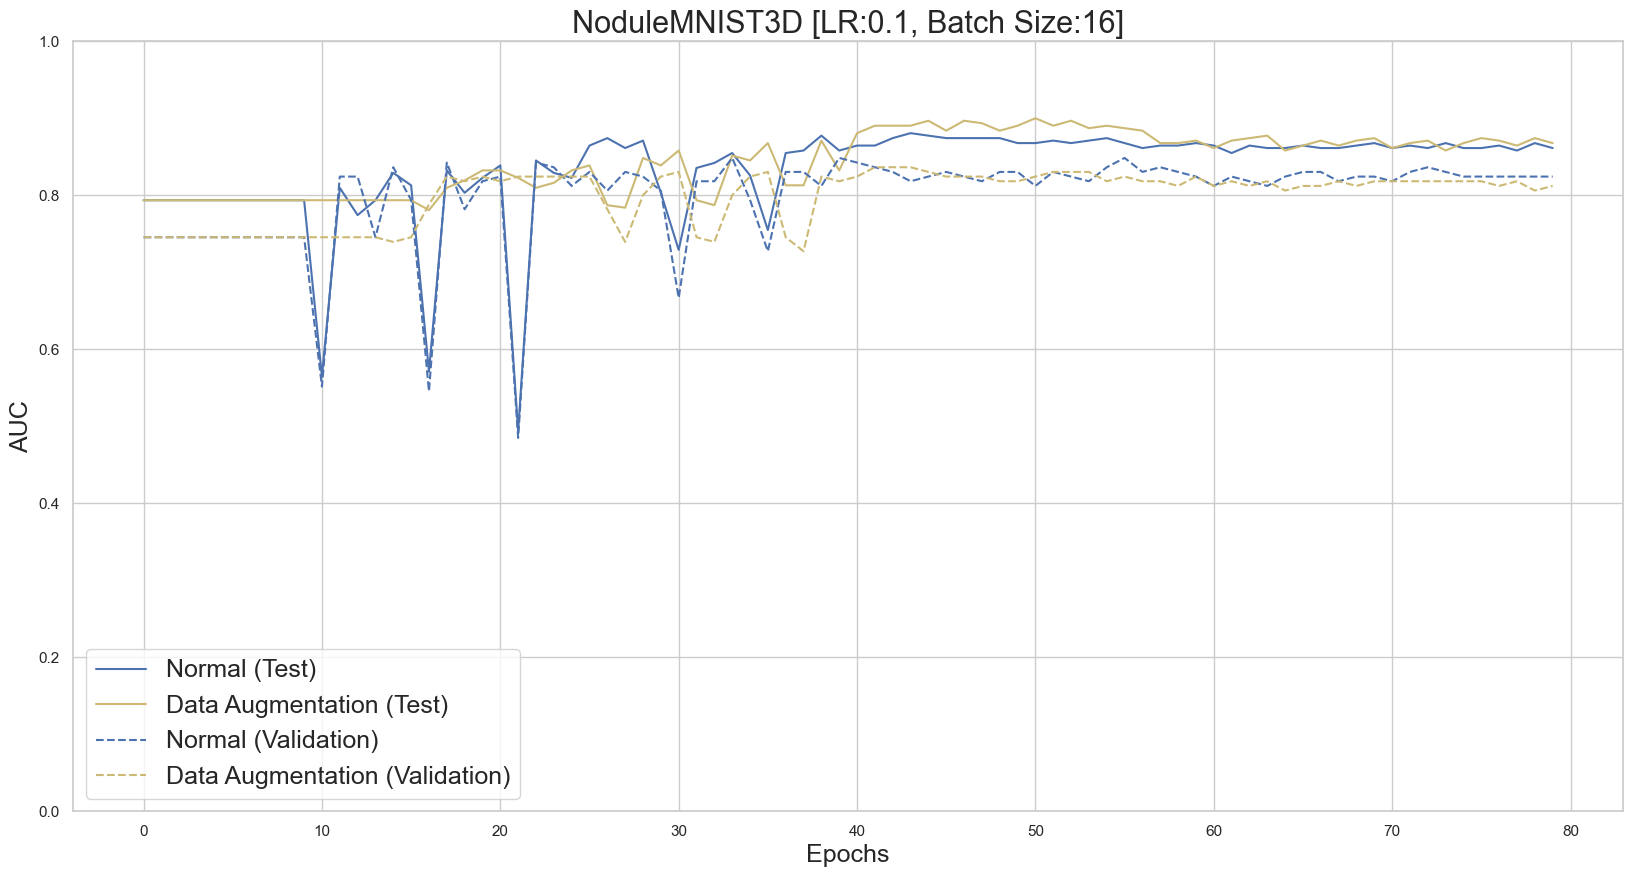

In [142]:
import seaborn as sns

# # Read from the Best Metric File file
# with open(r'E:\Deep_AUC_Optimization\Exps_using_val_scores\003_Vessel_Nodule_HP_tuninig_with_n_without_valset_modification\vesselmnist3d\Epoch_Logs\BatchSz_16_LR_0.1_Optimizer_PESG_LossFn_AUCM_Margin_1.0_EpochDecay_2e-05_WeightDecay_1e-07', 'r') as f:
#     data = json.loads(f.read())

path_1 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\011_Data_Augmentation\nodulemnist3d\Epoch_Logs\BSz_64_LR_1.0_Optim_PESG_LossFn_AUCM_Margin_1.0_ED_2e-05_WD_1e-07_DA'
# Read epoch logs
with open(path_1, 'r') as f:
    data = eval(f.read())
data_df = pd.DataFrame.from_dict(data)
data_df_1 = data_df.T
data_df_1['Epoch'] = [i for i in range(data_df_1.shape[0])]
# df_melted = data_df[['Epoch', 'test_auc', 'val_auc']].melt("Epoch",var_name="Auc Type",value_name="AUC")
# df_melted['Auc Type'] = df_melted['Auc Type'].apply(lambda x:x.split('_')[0].capitalize())
# df_melted.head()

path_2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\003_Vessel_Nodule_HP_tuninig_with_n_without_valset_modification\nodulemnist3d\Epoch_Logs\BatchSz_64_LR_1.0_Optimizer_PESG_LossFn_AUCM_Margin_1.0_EpochDecay_2e-05_WeightDecay_1e-07'
# Read epoch logs
with open(path_2, 'r') as f:
    data = eval(f.read())
data_df = pd.DataFrame.from_dict(data)
data_df_2 = data_df.T
data_df_2['Epoch'] = [i for i in range(data_df_2.shape[0])]
# df_melted = data_df[['Epoch', 'test_auc', 'val_auc']].melt("Epoch",var_name="Auc Type",value_name="AUC")
# df_melted['Auc Type'] = df_melted['Auc Type'].apply(lambda x:x.split('_')[0].capitalize())
# df_melted.head()



sns.set(style='whitegrid')
plt.figure(dpi=1200)
# sns.lineplot(x=[i for i in range(80)], y='test_auc', data=data_df.T, legend='auto')
# sns.lineplot(x=[i for i in range(80)], y='val_auc', data=data_df.T, legend = 'auto')
# sns.lineplot(x=[i for i in range(80)], y=['test_auc', 'val_auc'], data=data_df.T, legend = 'auto')
plt.figure(figsize=(20,10))
# sns.lineplot(x='Epoch', y='AUC', hue = 'Auc Type', data=df_melted)
# plt.plot(data_df_1['Epoch'], data_df_1['test_acc'], 'r')
plt.plot(data_df_2['Epoch'], data_df_2['test_acc'], 'b')
# plt.plot(data_df_3['Epoch'], data_df_3['test_acc'], 'k')
plt.plot(data_df_1['Epoch'], data_df_1['test_acc'], 'y')
# plt.plot(data_df_1['Epoch'], data_df_1['val_acc'], '--', 'r')
plt.plot(data_df_2['Epoch'], data_df_2['val_acc'], '--b')
# plt.plot(data_df_3['Epoch'], data_df_3['val_acc'], '--', 'k')
plt.plot(data_df_1['Epoch'], data_df_1['val_acc'], '--y')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('AUC', fontsize=18)
plt.ylim([0.0,1])
plt.title('NoduleMNIST3D [LR:0.1, Batch Size:16]', fontsize=22)
plt.legend(['Normal (Test)', 'Data Augmentation (Test)', 'Normal (Validation)', 'Data Augmentation (Validation)'], fontsize=18)
# plt.legend(fontsize=22)

### Weight Decay

<Figure size 7680x5760 with 0 Axes>

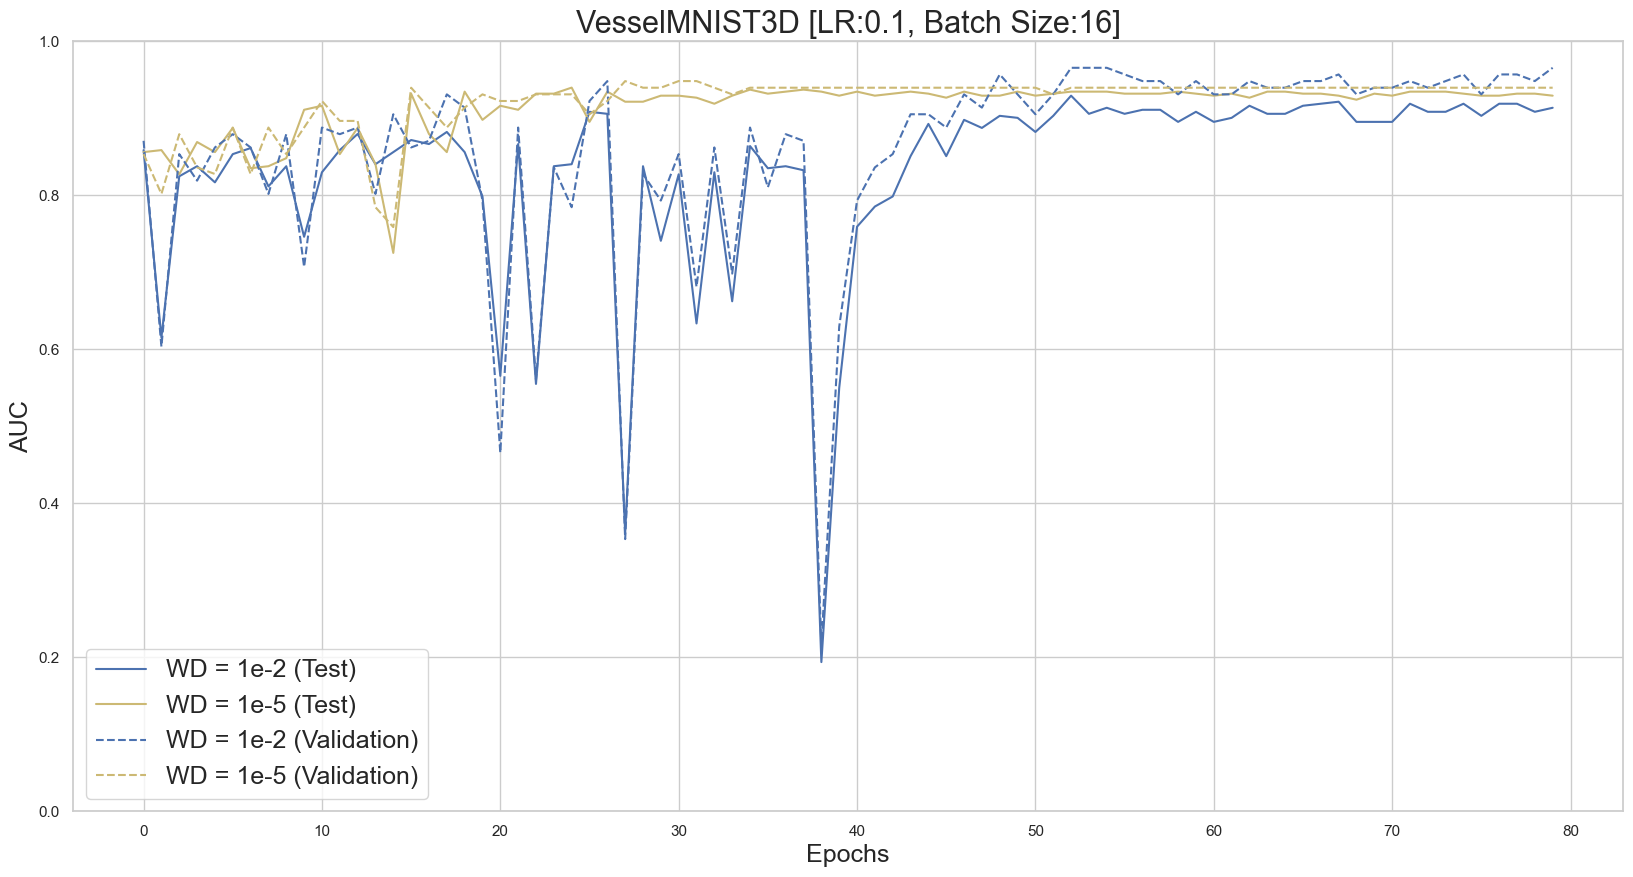

In [139]:
import seaborn as sns

# # Read from the Best Metric File file
# with open(r'E:\Deep_AUC_Optimization\Exps_using_val_scores\003_Vessel_Nodule_HP_tuninig_with_n_without_valset_modification\vesselmnist3d\Epoch_Logs\BatchSz_16_LR_0.1_Optimizer_PESG_LossFn_AUCM_Margin_1.0_EpochDecay_2e-05_WeightDecay_1e-07', 'r') as f:
#     data = json.loads(f.read())

path_1 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\vesselmnist3d\Epoch_Logs\BSz_16_LR_0.1_Optim_PESG_LossFn_AUCM_Margin_1.0_ED_2e-05_WD_0.001halve_val'
# Read epoch logs
with open(path_1, 'r') as f:
    data = eval(f.read())
data_df = pd.DataFrame.from_dict(data)
data_df_1 = data_df.T
data_df_1['Epoch'] = [i for i in range(data_df_1.shape[0])]
# df_melted = data_df[['Epoch', 'test_auc', 'val_auc']].melt("Epoch",var_name="Auc Type",value_name="AUC")
# df_melted['Auc Type'] = df_melted['Auc Type'].apply(lambda x:x.split('_')[0].capitalize())
# df_melted.head()

path_2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\vesselmnist3d\Epoch_Logs\BSz_16_LR_0.1_Optim_PESG_LossFn_AUCM_Margin_1.0_ED_2e-05_WD_0.01halve_val'
# Read epoch logs
with open(path_2, 'r') as f:
    data = eval(f.read())
data_df = pd.DataFrame.from_dict(data)
data_df_2 = data_df.T
data_df_2['Epoch'] = [i for i in range(data_df_2.shape[0])]
# df_melted = data_df[['Epoch', 'test_auc', 'val_auc']].melt("Epoch",var_name="Auc Type",value_name="AUC")
# df_melted['Auc Type'] = df_melted['Auc Type'].apply(lambda x:x.split('_')[0].capitalize())
# df_melted.head()
path_3 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\vesselmnist3d\Epoch_Logs\BSz_16_LR_0.1_Optim_PESG_LossFn_AUCM_Margin_1.0_ED_2e-05_WD_0.1halve_val'
# Read epoch logs
with open(path_3, 'r') as f:
    data = eval(f.read())
data_df = pd.DataFrame.from_dict(data)
data_df_3 = data_df.T
data_df_3['Epoch'] = [i for i in range(data_df_3.shape[0])]
# df_melted = data_df[['Epoch', 'test_auc', 'val_auc']].melt("Epoch",var_name="Auc Type",value_name="AUC")
# df_melted['Auc Type'] = df_melted['Auc Type'].apply(lambda x:x.split('_')[0].capitalize())
# df_melted.head()
path_4 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\vesselmnist3d\Epoch_Logs\BSz_16_LR_0.1_Optim_PESG_LossFn_AUCM_Margin_1.0_ED_2e-05_WD_1e-05halve_val'
# Read epoch logs
with open(path_4, 'r') as f:
    data = eval(f.read())
data_df = pd.DataFrame.from_dict(data)
data_df_4 = data_df.T
data_df_4['Epoch'] = [i for i in range(data_df_4.shape[0])]
# df_melted = data_df[['Epoch', 'test_auc', 'val_auc']].melt("Epoch",var_name="Auc Type",value_name="AUC")
# df_melted['Auc Type'] = df_melted['Auc Type'].apply(lambda x:x.split('_')[0].capitalize())
# df_melted.head()


sns.set(style='whitegrid')
plt.figure(dpi=1200)
# sns.lineplot(x=[i for i in range(80)], y='test_auc', data=data_df.T, legend='auto')
# sns.lineplot(x=[i for i in range(80)], y='val_auc', data=data_df.T, legend = 'auto')
# sns.lineplot(x=[i for i in range(80)], y=['test_auc', 'val_auc'], data=data_df.T, legend = 'auto')
plt.figure(figsize=(20,10))
# sns.lineplot(x='Epoch', y='AUC', hue = 'Auc Type', data=df_melted)
# plt.plot(data_df_1['Epoch'], data_df_1['test_acc'], 'r')
plt.plot(data_df_2['Epoch'], data_df_2['test_acc'], 'b')
# plt.plot(data_df_3['Epoch'], data_df_3['test_acc'], 'k')
plt.plot(data_df_4['Epoch'], data_df_4['test_acc'], 'y')
# plt.plot(data_df_1['Epoch'], data_df_1['val_acc'], '--', 'r')
plt.plot(data_df_2['Epoch'], data_df_2['val_acc'], '--b')
# plt.plot(data_df_3['Epoch'], data_df_3['val_acc'], '--', 'k')
plt.plot(data_df_4['Epoch'], data_df_4['val_acc'], '--y')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('AUC', fontsize=18)
plt.ylim([0.0,1])
plt.title('VesselMNIST3D [LR:0.1, Batch Size:16]', fontsize=22)
plt.legend(['WD = 1e-2 (Test)', 'WD = 1e-5 (Test)', 'WD = 1e-2 (Validation)', 'WD = 1e-5 (Validation)'], fontsize=18)
# plt.legend(fontsize=22)

### For single plots

In [116]:
# # Read from the Best Metric File file
# with open(r'E:\Deep_AUC_Optimization\Exps_using_val_scores\003_Vessel_Nodule_HP_tuninig_with_n_without_valset_modification\vesselmnist3d\Epoch_Logs\BatchSz_16_LR_0.1_Optimizer_PESG_LossFn_AUCM_Margin_1.0_EpochDecay_2e-05_WeightDecay_1e-07', 'r') as f:
#     data = json.loads(f.read())

path_1 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\vesselmnist3d\Epoch_Logs\BSz_16_LR_0.1_Optim_PESG_LossFn_AUCM_Margin_1.0_ED_2e-05_WD_0.001halve_val'
path_2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\vesselmnist3d\Epoch_Logs\BSz_16_LR_0.1_Optim_PESG_LossFn_AUCM_Margin_1.0_ED_2e-05_WD_0.01halve_val'
path_2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\vesselmnist3d\Epoch_Logs\BSz_16_LR_0.1_Optim_PESG_LossFn_AUCM_Margin_1.0_ED_2e-05_WD_0.1halve_val'
path_2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\vesselmnist3d\Epoch_Logs\BSz_16_LR_0.1_Optim_PESG_LossFn_AUCM_Margin_1.0_ED_2e-05_WD_1e-05halve_val'

# Read epoch logs
with open(path_1, 'r') as f:
    data = eval(f.read())

data_df = pd.DataFrame.from_dict(data)
data_df = data_df.T
data_df['Epoch'] = [i for i in range(data_df.shape[0])]

df_melted = data_df[['Epoch', 'test_auc', 'val_auc']].melt("Epoch",var_name="Auc Type",value_name="AUC")
df_melted['Auc Type'] = df_melted['Auc Type'].apply(lambda x:x.split('_')[0].capitalize())
df_melted.head()



,Epoch,Auc Type,AUC
0,0,Test,0.740413
1,1,Test,0.749331
2,2,Test,0.862112
3,3,Test,0.865816
4,4,Test,0.905193


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 7680x5760 with 0 Axes>

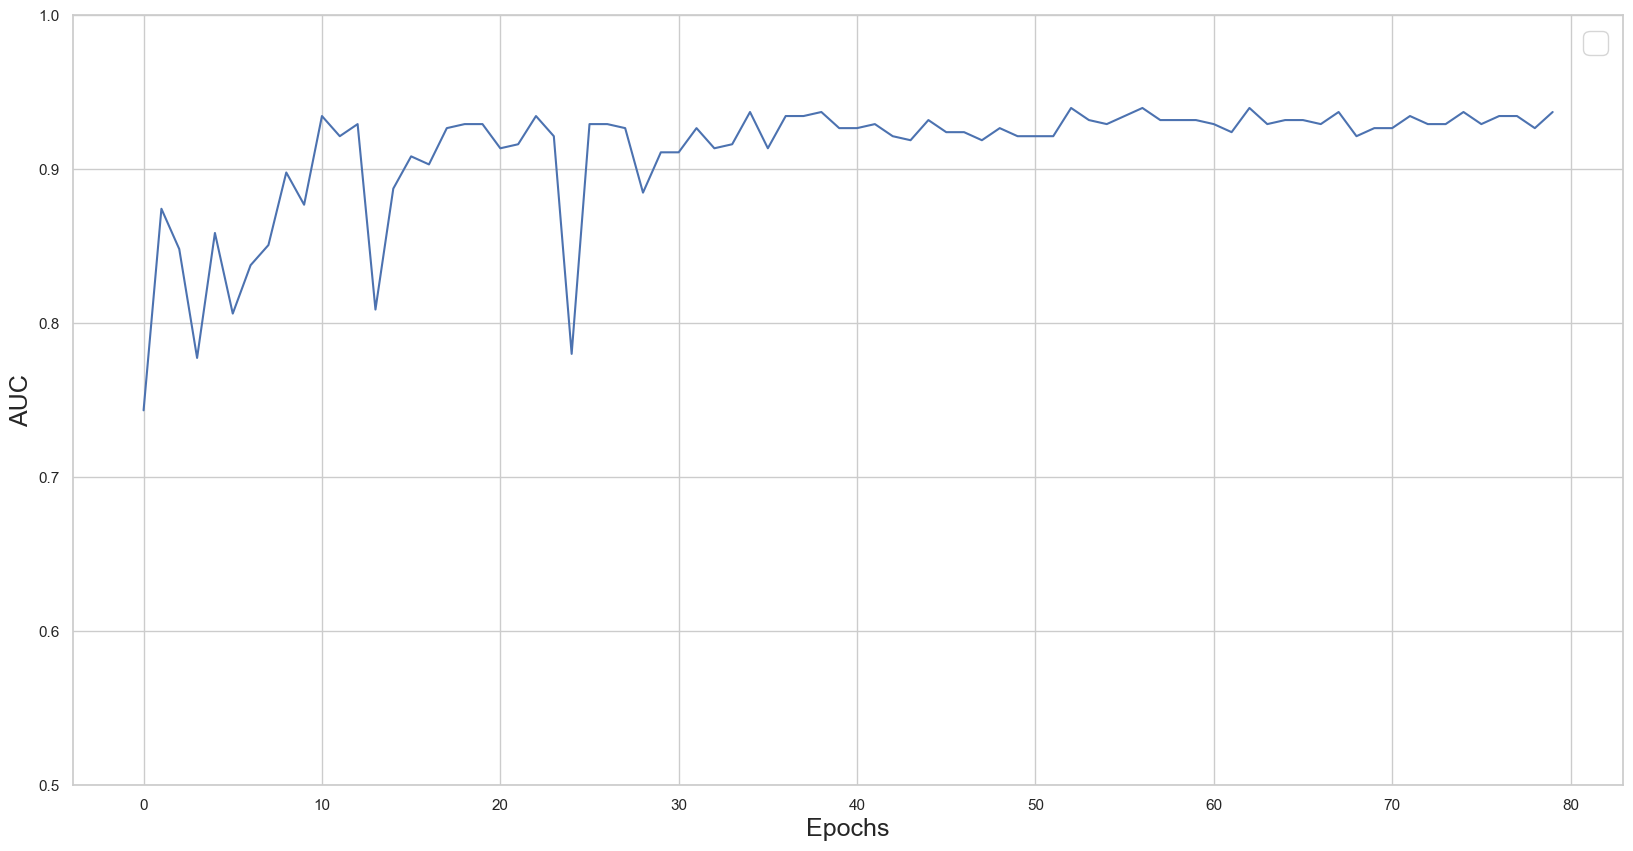

In [121]:
import seaborn as sns

sns.set(style='whitegrid')
plt.figure(dpi=1200)
# sns.lineplot(x=[i for i in range(80)], y='test_auc', data=data_df.T, legend='auto')
# sns.lineplot(x=[i for i in range(80)], y='val_auc', data=data_df.T, legend = 'auto')
# sns.lineplot(x=[i for i in range(80)], y=['test_auc', 'val_auc'], data=data_df.T, legend = 'auto')
plt.figure(figsize=(20,10))
# sns.lineplot(x='Epoch', y='AUC', hue = 'Auc Type', data=df_melted)
plt.plot(data_df['Epoch'], data_df['test_acc'])
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('AUC', fontsize=18)
plt.ylim([0.5,1])
# plt.title('VesselMNIST3D [LR:0.1, Batch Size:16]', fontsize=22)
plt.legend(fontsize=22)

In [38]:
data_df.T['test_auc'].max()

0.9444330109075941

# Function to analayze and visualize hyper parameter tuning

## For Optimizer

      lr  batch_size modify_datasets  weight_decay  val_auc   val_acc   
1  0.001          64                  1.000000e-07  0.71738  0.885417  \

   test_auc  test_acc  
1   0.58853  0.887435  



       data_flag output_root  num_epochs  gpu_ids  batch_size  download   
1  vesselmnist3d    ./output          80        0          64      True  \

   resize  as_rgb  model_path model_flag  ... imb_sampler  train_loss   
1    True   False         NaN   resnet18  ...       False    0.228165  \

   train_auc train_acc  val_loss  val_auc   val_acc  test_loss  test_auc   
1   0.601142   0.88764  1.574349  0.71738  0.885417   0.817576   0.58853  \

   test_acc  
1  0.887435  

[1 rows x 32 columns]


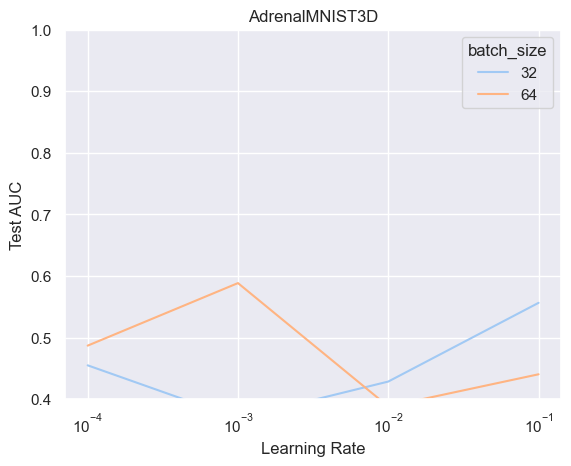

In [191]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set(style='darkgrid')
# plt.figure(dpi=300)

# path1 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\012_Optimizer_Adams_all_datasets_Run2/pneumoniamnist'
# path2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\009_Optimizer_Adam_all_datasets/pneumoniamnist'
# path1 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\012_Optimizer_Adams_all_datasets_Run2/breastmnist'
# path2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\009_Optimizer_Adam_all_datasets/breastmnist'
# path1 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\012_Optimizer_Adams_all_datasets_Run2/nodulemnist3d'
# path2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\009_Optimizer_Adam_all_datasets/nodulemnist3d'
# path1 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\012_Optimizer_Adams_all_datasets_Run2/vesselmnist3d'
# path2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\009_Optimizer_Adam_all_datasets/vesselmnist3d'
path1 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\012_Optimizer_Adams_all_datasets_Run2/synapsemnist3d'
path2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\009_Optimizer_Adam_all_datasets/synapsemnist3d'
# path1 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\012_Optimizer_Adams_all_datasets_Run2/adrenalmnist3d'
# path2 = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\009_Optimizer_Adam_all_datasets/adrenalmnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\002_Breastmnit_hyperparameter_tuning_without_valset_modification'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets/breastmnist'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets/nodulemnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets/vesselmnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\synapsemnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\adrenalmnist3d'

# with open(os.path.join(path, 'Best_metrics_of_each_run.txt'), 'r') as f:
#     data = json.loads(f.read())

df1 = pd.read_json(os.path.join(path1, 'Best_metrics_of_each_run.txt'))
df2 = pd.read_json(os.path.join(path2, 'Best_metrics_of_each_run.txt'))
df = pd.concat([df1, df2])

# ONLY PURE HP Tuning 
# df = df[df['modify_datasets']!='']


row = df[df['test_auc']==df['test_auc'].max()]
print(row[['lr', 'batch_size', 'modify_datasets', 'weight_decay','val_auc', 'val_acc', 'test_auc', 'test_acc']])
print("\n\n")
print(row)

# sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df)
# sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df, palette="pastel")
sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df[df['modify_datasets']==''], palette="pastel")
plt.xscale('log')
plt.ylim([0.4,1])
plt.xlabel('Learning Rate')
plt.ylabel('Test AUC')
# plt.title('BreastMNIST')
# plt.title('PneumoniaMNIST')
# plt.title('NoduleMNIST3D')
# plt.title('VesselMNIST3D')
# plt.title('SynapseMNIST3D')
plt.title('AdrenalMNIST3D')
# CHANGE_FNAME
plt.savefig(os.path.join(path, 'Result_plot.png'))
    # '../output/pneumoniamnist/Result_plot.png')

In [188]:
df['lr']

0    0.0010
1    0.0010
2    0.0001
3    0.0001
0    0.0100
1    0.0100
2    0.1000
3    0.1000
Name: lr, dtype: float64

### FOr Weight Decay

   lr  batch_size modify_datasets  weight_decay   val_auc   val_acc  test_auc   
0   1          16                       0.00001  0.996782  0.971374  0.968968  \

   test_acc  
0  0.891026  



        data_flag output_root  num_epochs  gpu_ids  batch_size  download   
0  pneumoniamnist    ./output          50        0          16      True  \

   resize  as_rgb  model_path model_flag  ... data_aug  train_loss  train_auc   
0    True   False         NaN   resnet18  ...    False  124.377123   0.998178  \

  train_acc    val_loss   val_auc   val_acc  test_loss  test_auc  test_acc  
0  0.987468  142.368628  0.996782  0.971374  73.302279  0.968968  0.891026  

[1 rows x 32 columns]


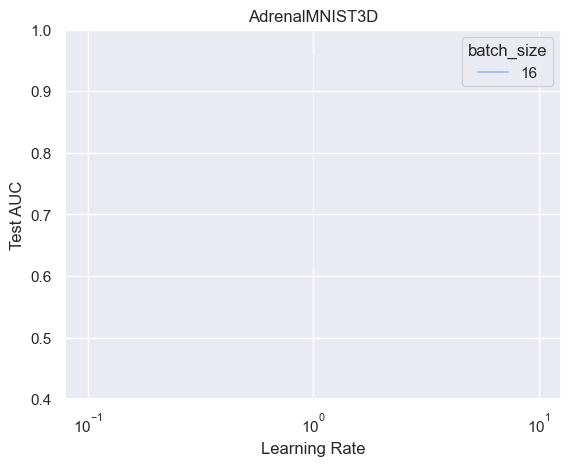

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set(style='darkgrid')
# plt.figure(dpi=300)

path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets/pneumoniamnist'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\002_Breastmnit_hyperparameter_tuning_without_valset_modification'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets/breastmnist'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets/nodulemnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets/vesselmnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\synapsemnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\010_Weight_Decay_all_datasets\adrenalmnist3d'

# with open(os.path.join(path, 'Best_metrics_of_each_run.txt'), 'r') as f:
#     data = json.loads(f.read())

df = pd.read_json(os.path.join(path, 'Best_metrics_of_each_run.txt'))


# ONLY PURE HP Tuning 
# df = df[df['modify_datasets']!='']


row = df[df['test_auc']==df['test_auc'].max()]
print(row[['lr', 'batch_size', 'modify_datasets', 'weight_decay','val_auc', 'val_acc', 'test_auc', 'test_acc']])
print("\n\n")
print(row)

# sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df)
# sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df, palette="pastel")
sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df[df['modify_datasets']==''], palette="pastel")
plt.xscale('log')
plt.ylim([0.4,1])
plt.xlabel('Learning Rate')
plt.ylabel('Test AUC')
# plt.title('BreastMNIST')
# plt.title('PneumoniaMNIST')
# plt.title('NoduleMNIST3D')
# plt.title('VesselMNIST3D')
# plt.title('SynapseMNIST3D')
plt.title('AdrenalMNIST3D')
# CHANGE_FNAME
plt.savefig(os.path.join(path, 'Result_plot.png'))
    # '../output/pneumoniamnist/Result_plot.png')

## For Data Augmentation

   lr  batch_size modify_datasets   val_auc   val_acc  test_auc  test_acc
0   1          64                  0.886566  0.830303  0.916413  0.896774



       data_flag output_root  num_epochs  gpu_ids  batch_size  download   
0  nodulemnist3d    ./output          80        0          64      True  \

   resize  as_rgb  model_path model_flag  ... data_aug  train_loss  train_auc   
0    True   False         NaN   resnet18  ...     True    43.43891   0.890437  \

  train_acc   val_loss   val_auc   val_acc  test_loss  test_auc  test_acc  
0  0.877375  50.713949  0.886566  0.830303  40.589924  0.916413  0.896774  

[1 rows x 32 columns]


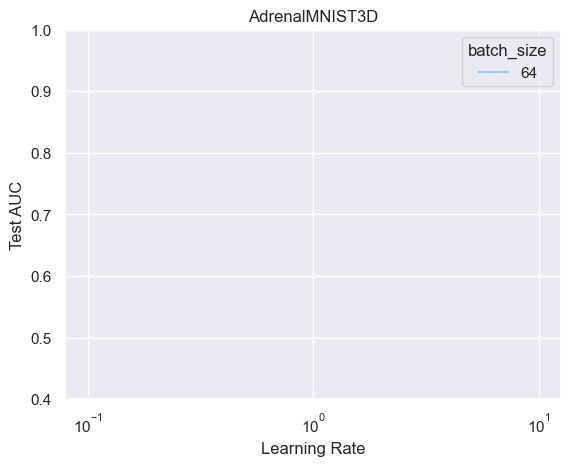

In [185]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set(style='darkgrid')
# plt.figure(dpi=300)

# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\011_Data_Augmentation/pneumoniamnist'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\002_Breastmnit_hyperparameter_tuning_without_valset_modification'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\011_Data_Augmentation/breastmnist'
path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\011_Data_Augmentation/nodulemnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\011_Data_Augmentation/vesselmnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\011_Data_Augmentation\synapsemnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\011_Data_Augmentation\adrenalmnist3d'

# with open(os.path.join(path, 'Best_metrics_of_each_run.txt'), 'r') as f:
#     data = json.loads(f.read())

df = pd.read_json(os.path.join(path, 'Best_metrics_of_each_run.txt'))


# ONLY PURE HP Tuning 
# df = df[df['modify_datasets']!='']


row = df[df['test_auc']==df['test_auc'].max()]
print(row[['lr', 'batch_size', 'modify_datasets', 'val_auc', 'val_acc', 'test_auc', 'test_acc']])
print("\n\n")
print(row)

# sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df)
# sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df, palette="pastel")
sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df[df['modify_datasets']==''], palette="pastel")
plt.xscale('log')
plt.ylim([0.4,1])
plt.xlabel('Learning Rate')
plt.ylabel('Test AUC')
# plt.title('BreastMNIST')
# plt.title('PneumoniaMNIST')
# plt.title('NoduleMNIST3D')
# plt.title('VesselMNIST3D')
# plt.title('SynapseMNIST3D')
plt.title('AdrenalMNIST3D')
# CHANGE_FNAME
plt.savefig(os.path.join(path, 'Result_plot.png'))
    # '../output/pneumoniamnist/Result_plot.png')

## For Method 1 and 2

     lr  batch_size modify_datasets   val_auc   val_acc  test_auc  test_acc
38  1.0          64                  0.869144  0.830303  0.901232   0.86129



        data_flag output_root  num_epochs  gpu_ids  batch_size  download   
38  nodulemnist3d    ./output          80        0          64     False  \

    resize  as_rgb  model_path model_flag  ... modify_datasets  train_loss   
38    True   False         NaN   resnet18  ...                   25.605513  \

    train_auc train_acc   val_loss   val_auc   val_acc  test_loss  test_auc   
38   0.920993  0.898964  26.711129  0.869144  0.830303  22.882444  0.901232  \

   test_acc  
38  0.86129  

[1 rows x 31 columns]


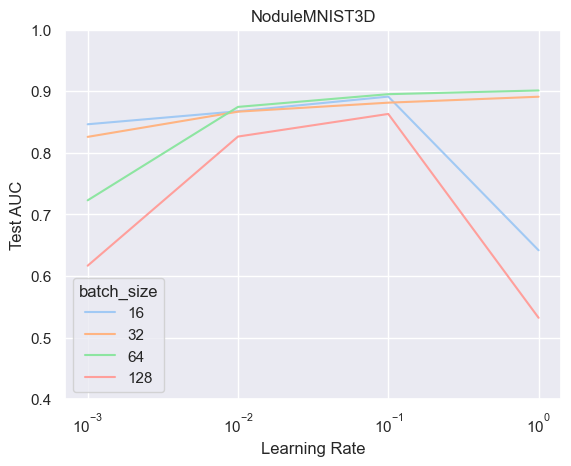

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set(style='darkgrid')
# plt.figure(dpi=20)

# path = 'E:/Deep_AUC_Optimization/Exps_using_val_scores/004_Pneumonia_hyperparameter_tuninh_with_n_without_valse_modification'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\002_Breastmnit_hyperparameter_tuning_without_valset_modification'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\001_Breastmnist_hyperparameter_tuning_with_valset_modification'
path = r'E:/Deep_AUC_Optimization/Exps_using_val_scores/003_Vessel_Nodule_HP_tuninig_with_n_without_valset_modification/nodulemnist3d'
# path = r'E:/Deep_AUC_Optimization/Exps_using_val_scores/003_Vessel_Nodule_HP_tuninig_with_n_without_valset_modification/vesselmnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\007_Adrenal_Synapse_HP_tuninh_with_n_without_valset_modification\synapsemnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\007_Adrenal_Synapse_HP_tuninh_with_n_without_valset_modification\adrenalmnist3d'

# with open(os.path.join(path, 'Best_metrics_of_each_run.txt'), 'r') as f:
#     data = json.loads(f.read())

df = pd.read_json(os.path.join(path, 'Best_metrics_of_each_run.txt'))


# ONLY PURE HP Tuning 
df = df[df['modify_datasets']=='']


row = df[df['test_auc']==df['test_auc'].max()]
print(row[['lr', 'batch_size', 'modify_datasets', 'val_auc', 'val_acc', 'test_auc', 'test_acc']])
print("\n\n")
print(row)

# sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df)
# sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df, palette="pastel")
sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df[df['modify_datasets']==''], palette="pastel")
plt.xscale('log')
plt.ylim([0.4,1])
plt.xlabel('Learning Rate')
plt.ylabel('Test AUC')
# plt.title('BreastMNIST')
# plt.title('PneumoniaMNIST')
plt.title('NoduleMNIST3D')
# plt.title('VesselMNIST3D')
# plt.title('SynapseMNIST3D')
# plt.title('AdrenalMNIST3D')
# CHANGE_FNAME
plt.savefig(os.path.join(path, 'Result_plot.png'))
    # '../output/pneumoniamnist/Result_plot.png')

In [72]:
row['lr']

41    0.1
Name: lr, dtype: float64

In [18]:
df

,data_flag,output_root,num_epochs,gpu_ids,batch_size,download,resize,as_rgb,model_path,model_flag,...,modify_datasets,train_loss,train_auc,train_acc,val_loss,val_auc,val_acc,test_loss,test_auc,test_acc
0,pneumoniamnist,./output,80,0,128,True,True,False,NaN,resnet18,...,double_val,636.744875,0.997764,0.989218,507.931521,0.997682,0.973248,225.337476,0.962579,0.884615
1,pneumoniamnist,./output,80,0,128,True,True,False,NaN,resnet18,...,double_val,24.066438,0.999262,0.998877,17.423916,0.997232,0.971975,14.988414,0.942187,0.875000
2,pneumoniamnist,./output,80,0,128,True,True,False,NaN,resnet18,...,double_val,10.351634,0.997747,0.975292,8.323158,0.993317,0.950318,5.812288,0.926507,0.862179
3,pneumoniamnist,./output,80,0,128,True,True,False,NaN,resnet18,...,double_val,4.452575,0.991056,0.887466,3.581794,0.986015,0.858599,2.510665,0.925816,0.854167
4,pneumoniamnist,./output,80,0,64,True,True,False,NaN,resnet18,...,double_val,534.914664,0.997870,0.991015,386.891940,0.998302,0.982166,181.683089,0.959402,0.881410
5,pneumoniamnist,./output,80,0,64,True,True,False,NaN,resnet18,...,double_val,22.599256,0.998642,0.997080,16.643660,0.997087,0.977070,16.794341,0.943360,0.879808
6,pneumoniamnist,./output,80,0,64,True,True,False,NaN,resnet18,...,double_val,11.980517,0.998751,0.993486,8.861633,0.993665,0.968153,7.778589,0.900778,0.850962
7,pneumoniamnist,./output,80,0,64,True,True,False,NaN,resnet18,...,double_val,7.021984,0.996892,0.970126,5.145896,0.991899,0.936306,3.872626,0.916294,0.846154
8,pneumoniamnist,./output,80,0,32,True,True,False,NaN,resnet18,...,double_val,429.586688,0.996731,0.961590,353.518239,0.997835,0.955414,252.573588,0.949693,0.900641
9,pneumoniamnist,./output,80,0,32,True,True,False,NaN,resnet18,...,double_val,22.728160,0.999227,0.997305,15.404532,0.997385,0.973248,17.844774,0.928885,0.854167


In [152]:
df[(df['lr']==0.1) & (df['batch_size']==32) ]

,data_flag,output_root,num_epochs,gpu_ids,batch_size,download,resize,as_rgb,model_path,model_flag,...,run,train_loss,train_auc,train_acc,val_loss,val_auc,val_acc,test_loss,test_auc,test_acc
17,vesselmnist3d,./output,50,0,32,False,True,False,NaN,resnet18,...,model1,0.338211,0.99371,0.976779,1.48986,0.899198,0.895833,0.861951,0.934486,0.905759


In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# path = 'E:/Deep_AUC_Optimization/Exps_using_val_scores/003_Vessel_Nodule_HP_tuninig_with_n_without_valset_modification/vesselmnist3d'
# path = 'E:/Deep_AUC_Optimization/Exps_using_val_scores/003_Vessel_Nodule_HP_tuninig_with_n_without_valset_modification/nodulemnist3d'
# path =  r'E:\Deep_AUC_Optimization\Exps_using_val_scores\004_Pneumonia_hyperparameter_tuninh_with_n_without_valse_modification'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\002_Breastmnit_hyperparameter_tuning_without_valset_modification'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\001_Breastmnist_hyperparameter_tuning_with_valset_modification'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\005_Pneumonia_LR_tuning_with_n_without_valse_modification'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\007_Adrenal_Synapse_HP_tuninh_with_n_without_valset_modification\adrenalmnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\007_Adrenal_Synapse_HP_tuninh_with_n_without_valset_modification\synapsemnist3d'

# DATA AUGMENTATION
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\008_Data_augmentaion_all_dsets\breastmnist'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\008_Data_augmentaion_all_dsets\vesselmnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\008_Data_augmentaion_all_dsets\synapsemnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\008_Data_augmentaion_all_dsets\adrenalmnist3d'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\008_Data_augmentaion_all_dsets\nodulemnist3d'
path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\008_Data_augmentaion_all_dsets\pneumoniamnist'

# # Weight Decay
# path = r'E:\Deep_AUC_Optimization\output\breastmnist'
# path = r'E:\Deep_AUC_Optimization\output\pneumoniamnist'
# path = r'E:\Deep_AUC_Optimization\output\nodulemnist3d'
# path = r'E:\Deep_AUC_Optimization\output\synapsemnist3d'

# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\008_Trial1_Data_augmentaion_all_dsets\pneumoniamnist'
# path = r'E:\Deep_AUC_Optimization\Exps_using_val_scores\008_Trial1_Data_augmentaion_all_dsets\breastmnist'

# with open(os.path.join(path, 'Best_metrics_of_each_run.txt'), 'r') as f:
#     data = json.loads(f.read())

df = pd.read_json(os.path.join(path, 'Best_metrics_of_each_run.txt'))
row = df[df['test_auc']==df['test_auc'].max()]
print(row)

# sns.lineplot(x='lr', y='test_auc', hue='batch_size', data=df)
sns.lineplot(x='weight_decay', y='test_auc', hue='lr', data=df, palette="pastel")
plt.xscale('log')
# CHANGE_FNAME
plt.savefig(os.path.join(path, 'Result_plot.png'))
    # '../output/pneumoniamnist/Result_plot.png')

ValueError: Expected object or value

In [180]:
row['lr']

7    0.1
Name: lr, dtype: float64

In [177]:
row['batch_size']

7    32
Name: batch_size, dtype: int64

In [61]:
df

,data_flag,output_root,num_epochs,gpu_ids,batch_size,download,resize,as_rgb,model_path,model_flag,...,data_aug,train_loss,train_auc,train_acc,val_loss,val_auc,val_acc,test_loss,test_auc,test_acc
0,breastmnist,./output,80,0,32,False,True,False,NaN,resnet18,...,False,1.905687,0.771827,0.804305,0.172960,0.727894,0.672414,0.221923,0.708647,0.698718
1,breastmnist,./output,80,0,32,False,True,False,NaN,resnet18,...,False,21.369917,0.572813,0.270059,50.081568,0.578368,0.267241,49.625169,0.509190,0.269231
2,breastmnist,./output,80,0,32,False,True,False,NaN,resnet18,...,False,1.977945,0.762016,0.450098,1.796382,0.755408,0.732759,1.810073,0.727026,0.730769
3,breastmnist,./output,80,0,32,False,True,False,NaN,resnet18,...,False,21.326732,0.572405,0.270059,49.843625,0.578368,0.267241,49.389334,0.508772,0.269231
4,breastmnist,./output,80,0,32,False,True,False,NaN,resnet18,...,False,20.949602,0.570132,0.270059,47.754375,0.581404,0.267241,47.321322,0.510652,0.269231
5,breastmnist,./output,80,0,32,False,True,False,NaN,resnet18,...,False,6.641824,0.961009,0.915851,0.241004,0.751423,0.706897,0.204379,0.763784,0.666667
6,breastmnist,./output,80,0,32,False,True,False,NaN,resnet18,...,False,0.455974,0.688076,0.270059,0.367892,0.669829,0.267241,0.365107,0.540309,0.269231
7,breastmnist,./output,80,0,32,False,True,False,NaN,resnet18,...,False,15.982568,0.906283,0.704501,1.608456,0.774573,0.758621,1.997882,0.750835,0.743590
8,breastmnist,./output,80,0,32,False,True,False,NaN,resnet18,...,False,15.035023,0.911684,0.708415,18.632988,0.717268,0.732759,19.644391,0.712197,0.730769
9,breastmnist,./output,80,0,32,False,True,False,NaN,resnet18,...,False,10.390290,0.980417,0.947162,1.589969,0.805693,0.706897,1.814446,0.751253,0.717949


In [62]:
df['lr']

0     1.00
1     1.00
2     1.00
3     1.00
4     1.00
5     0.10
6     0.10
7     0.10
8     0.10
9     0.10
10    0.01
11    0.01
12    0.01
13    0.01
14    0.01
Name: lr, dtype: float64

In [63]:
df['weight_decay']

0     1.000000e-03
1     1.000000e-07
2     1.000000e-02
3     1.000000e-05
4     1.000000e-04
5     1.000000e-03
6     1.000000e-07
7     1.000000e-02
8     1.000000e-05
9     1.000000e-04
10    1.000000e-03
11    1.000000e-07
12    1.000000e-02
13    1.000000e-05
14    1.000000e-04
Name: weight_decay, dtype: float64

In [160]:
Image.open(train_dataset.imgs[0])

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [162]:
plt.imshow(torch.Tensor(train_dataset.imgs[0]).permute(1, 2, 0)  )

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

[1]


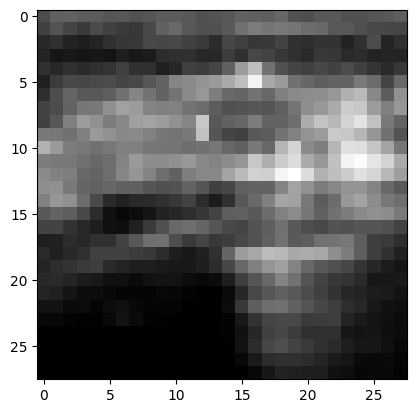

In [180]:
i = 205

print(train_dataset.labels[i])
plt.imshow(train_dataset.imgs[i], cmap='gray')

In [184]:
np.unique(train_dataset.labels, return_counts=True)

(array([0, 1], dtype=uint8), array([147, 399], dtype=int64))

In [185]:
np.unique(val_dataset.labels, return_counts=True)

(array([0, 1], dtype=uint8), array([21, 57], dtype=int64))

In [188]:
np.unique(test_dataset.labels, return_counts=True)

(array([0, 1], dtype=uint8), array([ 42, 114], dtype=int64))

In [186]:
399/147

2.7142857142857144

In [187]:
57/21

2.7142857142857144

In [189]:
114/42

2.7142857142857144

In [190]:
mixed_dataset = torch.concat(train_dataset + val_dataset

In [291]:
import random
import copy


def halve_val_dset(train_dataset, val_dataset):
    val_pos_indices = np.where(val_dataset.labels==1)[0]
    val_neg_indices = np.where(val_dataset.labels==0)[0]
    val_pos_indices_to_transfer = np.random.choice(val_pos_indices, size = len(val_pos_indices)//2)
    val_neg_indices_to_transfer = np.random.choice(val_neg_indices, size = len(val_neg_indices)//2)
    val_indices_to_transfer = np.concatenate((val_pos_indices_to_transfer, val_neg_indices_to_transfer))
    val_indices_not_transfer = [i for i in range(val_dataset.imgs.shape[0]) if i not in val_indices_to_transfer]

    train_dataset_v1 = copy.deepcopy(train_dataset)
    train_dataset_v1.imgs = np.concatenate((train_dataset_v1.imgs, val_dataset.imgs[val_indices_to_transfer,:,:]), axis=0)
    train_dataset_v1.labels = np.concatenate((train_dataset.labels, val_dataset.labels[val_indices_to_transfer]), axis=0)

    val_dataset_v1 = copy.deepcopy(val_dataset)
    val_dataset_v1.imgs = val_dataset.imgs[val_indices_not_transfer,:,:]
    val_dataset_v1.labels = val_dataset.labels[val_indices_not_transfer]

    return train_dataset_v1, val_dataset_v1

: 

In [262]:
def double_val_dset(train_dataset, val_dataset):
    """
    Makes Validation set 1.5 times
    """
    train_pos_indices = np.where(train_dataset.labels==1)[0]
    train_neg_indices = np.where(train_dataset.labels==0)[0]

    val_pos_indices = np.where(val_dataset.labels==1)[0]
    val_neg_indices = np.where(val_dataset.labels==0)[0]

    train_pos_indices_to_transfer = np.random.choice(train_pos_indices, size = len(val_pos_indices)//2)
    train_neg_indices_to_transfer = np.random.choice(train_neg_indices, size = len(val_neg_indices)//2)
    train_indices_to_transfer = np.concatenate((train_pos_indices_to_transfer, train_neg_indices_to_transfer))
    train_indices_not_transfer = [i for i in range(train_dataset.imgs.shape[0]) if i not in train_indices_to_transfer]

    train_dataset_v1 = copy.deepcopy(train_dataset)
    train_dataset_v1.imgs = train_dataset.imgs[train_indices_not_transfer,:,:]
    train_dataset_v1.labels = train_dataset.labels[train_indices_not_transfer]
    # train_dataset_v1.imgs = np.concatenate((train_dataset_v1.imgs, val_dataset.imgs[val_indices_to_transfer,:,:]), axis=0)
    val_dataset_v1 = copy.deepcopy(val_dataset)
    val_dataset_v1.imgs = np.concatenate((val_dataset_v1.imgs, train_dataset.imgs[train_indices_to_transfer,:,:]), axis=0)
    val_dataset_v1.labels = np.concatenate((val_dataset_v1.labels, train_dataset.labels[train_indices_to_transfer]), axis=0)

    return train_dataset_v1, val_dataset_v1

In [263]:
train_dataset_v1, val_dataset_v1 = double_val_dset(train_dataset, val_dataset)


In [286]:
train_dataset_v1, val_dataset_v1 = halve_val_dset(train_dataset, val_dataset)


In [287]:
val_dataset_v1.imgs.shape

(46, 28, 28)

In [290]:
train_dataset.labels.shape

(546, 1)

In [232]:

op = outputs.cpu()
tg = targets.cpu()
sigmoid = nn.Sigmoid()
roc_auc_score(tg, [pred[1] for pred in sigmoid(op)])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 9,
 11,
 12,
 14,
 15,
 21,
 22,
 25,
 27,
 29,
 30,
 31,
 34,
 37,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 52,
 54,
 55,
 56,
 57,
 58,
 60,
 64,
 67,
 68,
 69,
 70,
 71,
 73,
 75,
 76,
 77]

In [224]:
train_dataset.imgs.shape

(546, 28, 28)